In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from dataset import Dataset
from tools import getDataset, print_class_distribution

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("MPS device not found.")
print('Device:', device)

Device: mps


In [3]:
batch_size = 128
num_workers = 4
learning_rate = 0.0001 
num_epochs = 15
image_size = 84
num_classes = 50

root_dir = os.path.join(os.getcwd(), 'datasets/miniImageNet')
dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes)


train_transforms = transforms.Compose(
        [
            transforms.RandomCrop(84, padding=8),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

transforms = transforms.Compose(
        [
            transforms.RandomCrop(84, padding=8),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )
       
train_dataset, temp_dataset = train_test_split(dataset, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=0.5, random_state=42)
      
train_dataset = Dataset(dataset=train_dataset, path=root_dir, phase='train', transform=train_transforms)
val_dataset = Dataset(dataset=val_dataset, path=root_dir, phase='val', transform=transforms)
test_dataset = Dataset(dataset=test_dataset, path=root_dir, phase='test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [4]:
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing/evaluating -> batch: %d correct: %d numb images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, train_loader, valid_loader):

    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(params= net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, betas=(0.5, 0.999))
    scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        net.train()
        correct = 0.0  # used to accumulate number of correctly recognized images
        num_images = 0.0  # used to accumulate number of images
        total_loss = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output_train = net(images)
            loss = criterion(output_train, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicts = output_train.argmax(dim=1)
            correct += predicts.eq(labels).sum().item()
            num_images += len(labels)
            total_loss += loss.item()

            print('training -> epoch: %d, batch: %d, loss: %f' % (epoch, i_batch, loss.item()) + '\r', end='')

        print()
        acc = correct / num_images
        acc_eval, val_loss = eval(net, valid_loader)
        average_loss = total_loss / len(train_loader)
        training_losses.append(average_loss)
        val_losses.append(val_loss)
        print('\nepoch: %d, lr: %f, accuracy: %f, avg. loss: %f, valid accuracy: %f valid loss: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_eval, val_loss))

        scheduler.step()

    return net, training_losses, val_losses

Hyperparameters:
Batch Size: 128
Learning Rate: 0.0001
Number of Epochs: 15
Number of Workers: 4
Number of Classes: 50

training -> epoch: 0, batch: 160, loss: 1.363324
testing/evaluating -> batch: 34 correct: 2911 numb images: 4410
epoch: 0, lr: 0.000100, accuracy: 0.454762, avg. loss: 2.172634, valid accuracy: 0.660091 valid loss: 1.234287

training -> epoch: 1, batch: 160, loss: 1.004573
testing/evaluating -> batch: 34 correct: 3127 numb images: 4410
epoch: 1, lr: 0.000100, accuracy: 0.666910, avg. loss: 1.195308, valid accuracy: 0.709070 valid loss: 1.017632

training -> epoch: 2, batch: 160, loss: 0.902923
testing/evaluating -> batch: 34 correct: 3185 numb images: 4410
epoch: 2, lr: 0.000100, accuracy: 0.725316, avg. loss: 0.949964, valid accuracy: 0.722222 valid loss: 0.963299

training -> epoch: 3, batch: 160, loss: 0.887272
testing/evaluating -> batch: 34 correct: 3218 numb images: 4410
epoch: 3, lr: 0.000100, accuracy: 0.767833, avg. loss: 0.800124, valid accuracy: 0.729705 va

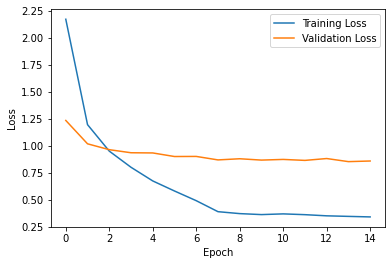

In [5]:
from models.resnet18 import ResNet18

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}")
print(f"Number of Classes: {num_classes}\n")

# print_class_distribution(train_dataset, "Training", label_mapping)
# print_class_distribution(val_dataset, "Validation", label_mapping)
# print_class_distribution(test_dataset, "Testing", label_mapping)

model = ResNet18(num_classes=num_classes).to(device)
model, training_losses, val_losses = train(net=model, train_loader=train_loader, valid_loader=validation_loader)

acc_test, test_loss = eval(model, test_loader)
print('\naccuracy on testing data: %f' % acc_test)

plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
torch.save(model, os.path.join(os.getcwd(), 'pretrained/resnet18_adam_best.pth'))

In [11]:
model.eval()  

for i_batch, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outs = model(images)
    _, predicted = torch.max(outs.data, 1)
    print(predicted)
    print(labels)
    _, predicted = torch.max(outs.data, 1)
    correct = (predicted == labels).sum().item()
    print(correct, len(labels))
    break

tensor([12,  8,  2,  7, 11, 37, 32, 39, 46, 22, 23, 47, 40, 45,  4, 18, 47,  0,
        14, 29, 22, 43, 14,  6,  4, 27, 19, 16, 47, 24,  8, 12, 28, 10, 28, 47,
        41, 37, 18, 34, 36,  9, 13, 12, 27,  7,  6, 30, 17, 17,  2, 20, 12,  3,
        10, 17, 27, 22, 33, 38, 27, 39,  5, 39, 27, 42,  1, 17, 26, 24, 48, 13,
        35, 33, 48, 39,  4,  7, 33, 24, 33, 41, 11, 38,  3,  7, 46,  0, 39, 10,
        24, 31,  5, 39, 30, 20, 17, 22, 30, 43, 10, 26, 48, 21, 48,  1, 16, 33,
         6, 23, 23, 47,  7, 48,  1,  0, 34,  6, 42, 17, 31, 10, 32, 38, 25,  9,
        47, 41], device='mps:0')
tensor([12,  8,  2,  7, 11, 37,  2, 39, 10, 22, 23, 47, 40, 45,  4, 18, 47,  0,
        14, 29, 22, 22,  1,  6,  0, 27, 19, 16, 47, 24,  8, 12, 28, 10, 28, 47,
        41, 37, 18, 19, 36,  9, 45, 12, 27,  7,  6, 30, 25, 17,  2, 20, 12,  3,
        10, 17, 27, 22,  3, 38, 27,  8,  5, 39, 27, 42,  1, 17, 17, 24, 48, 36,
        35, 33, 48, 39,  4,  7, 41, 24, 45, 33, 11, 38,  3,  7, 46,  3, 39, 10,
       

In [9]:
104/128

0.8125